In [ ]:
import networkx as nx
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg # to show png
from collections import Counter
import numpy as np
import scripts.degree as degree # for plotting degree distribution
import scripts.summary as summary 
from scripts.plots import CCDF 

# Basic Network Description

1. Basic network description of your data (what type of network it is, what does it represent, is it real or synthetically generated, etc). In practice, the result of project phase #1 (finding data).

https://networks.skewed.de/net/arxiv_authors#GrQc

Scientific collaborations between authors of papers submitted to arxiv.org, under 5 categories: gr-qc (general relativity and quantum cosmology), astro-ph (astro physics), cond-mat (condensed matter), hep-ph (high energy physics), and hep-th (high energy theory) categories, spanning January 1993 to April 2003. 

If an author i co-authored a paper with author j, the graph contains an undirected edge from i to j. If the paper is co-authored by k authors this generates a completely connected (sub)graph on k nodes (there is an edge if authors coauthored at least one paper).

We chose the network GrQc, which stands for General Relativity and Quantum Cosmology. 

General Relativity: General relativity, also known as the general theory of relativity and Einstein's theory of gravity, is the geometric theory of gravitation published by Albert Einstein in 1915 and is the current description of gravitation in modern physics.

Quantum Cosmology: Quantum cosmology is the attempt in theoretical physics to develop a quantum theory of the universe. This approach attempts to answer open questions of classical physical cosmology, particularly those related to the first phases of the universe.

Link til research paper: http://www.cs.cmu.edu/~jure/pubs/powergrowth-tkdd.pdf

Link to our network: http://snap.stanford.edu/data/ca-GrQc.html

Link to all the collaboration networks: http://snap.stanford.edu/data/index.html#canets

# Exploratory Data Analysis

## Whole Network

2. Basic network statistics of your data (number of nodes, edges, clustering, degree distribution, etc). In practice, the result of project phase #2 (exploratory data analysis).

Number of nodes: 5242 ????

Number of edges: 28,980 (14,490)

2. 1. Statistics of data after removing irrelevant nodes:

Number of nodes: 4158

Number of edges: 13,428

In [ ]:
# Load data

edge_df = pd.read_csv("data/edges.csv", delimiter=",")
node_df = pd.read_csv("data/nodes.csv", delimiter=",")


In [ ]:
# Turn into networkx graph

G = nx.from_pandas_edgelist(edge_df, source="# source", target=" target", create_using=nx.Graph())

### Summary of whole network

In [ ]:
no_edges = nx.number_of_edges(G)
no_nodes = nx.number_of_nodes(G)

print(f'Number of edges in whole network: {no_edges}')
print(f'Number of nodes in whole network: {no_nodes}')


Number of edges in whole network: 14496
Number of nodes in whole network: 5242


### Plot of network

In [ ]:
# Make plot of network.
%%script echo skipping
fig, ax = plt.subplots(figsize=(15,10))

pos = nx.spring_layout(G, seed=7)
nx.draw_networkx_nodes(G, pos, node_size=1)
nx.draw_networkx_edges(G, pos)
plt.savefig("figures/graph_with_edges.png")

UsageError: Line magic function `%%script` not found.


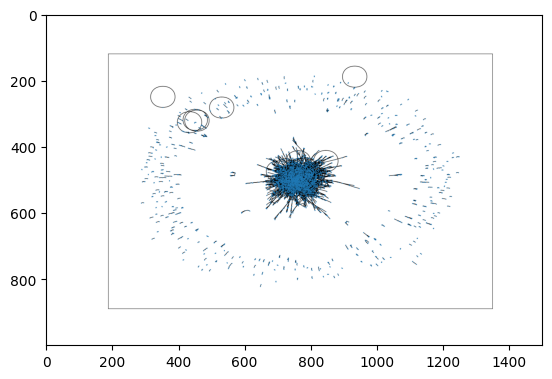

In [ ]:
img = mpimg.imread('figures/graph_with_edges.png')
imgplot = plt.imshow(img)
plt.show()

### Degree Distribution

A degree distribution is a degree scatter plot, the degree on the x-axis and the number of nodes on the y-axis.

Commonly, one would normalise the y-axis by dividing its values by the number of nodes in the network, and the y-axis is the probability if a node to have a degree equal to k.

Generate a csv file containing the node and the corresponding degree of that node, and save it into the data folder as node_list_degrees.

In [ ]:
#node_df2 = pd.DataFrame(sorted(dict(nx.degree(G)).items()))
#node_df2.rename(columns={0:"Node_id",1:"Degree"}, inplace=True)
#node_df2.to_csv("data/node_list_degrees.csv", index=False)

/shared-libs/python3.8/py/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1041: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


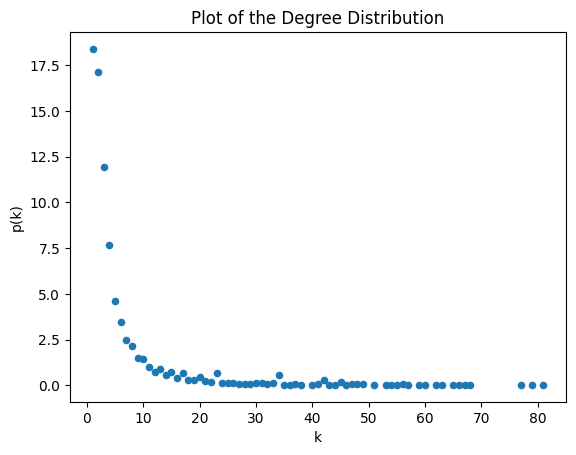

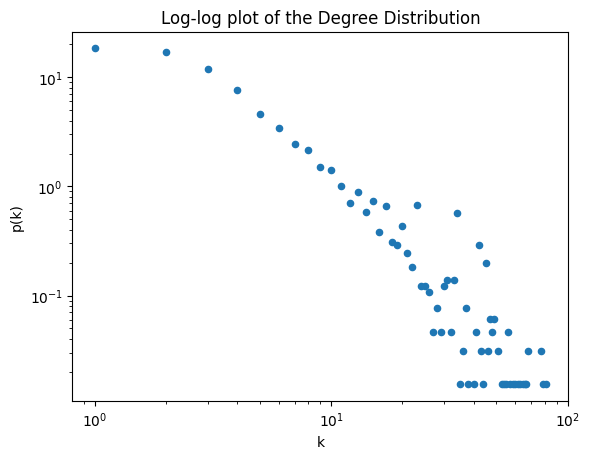

In [ ]:
node_list_degrees = pd.read_csv("data/node_list_degrees.csv")

df_degrees = degree.make_df(node_list_degrees)

degree.plot_degree(df_degrees)

degree.plot_degree_log(df_degrees)


### The CCDF of the degree distribution (the complement of a cumulative distribution function)
The most common way to visualize degrees is by drawing cumulative distributions (CDF)

To make the CCDF we need to know how many nodes have degree equal to, or higher than a specific value. So we sort the dataframe in descending degree order, so that the pandas cumsum function will calculate that for us. Then we normalize by the total degree sum, so that the count becomes a probability. We then sort in ascending degree value, to respect the convention.

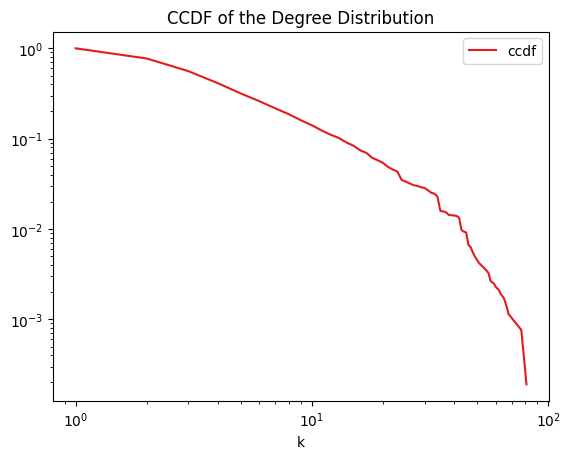

In [ ]:
CCDF(df_degrees)

Description of CCDF

y: the probability of finding a node of degree k or higher

x: degree

CCDF Fit: 8.6089 x ^ -1.8811 (R2 = 0.8639, p = 0.0000)


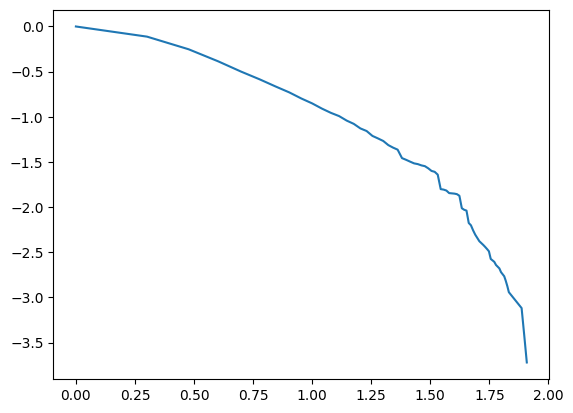

Calculating best minimal value for power law fit
/opt/conda/lib/python3.8/site-packages/powerlaw.py:699: RuntimeWarning: invalid value encountered in divide
  (CDF_diff**2) /
Powerlaw CCDF Fit: 10.8487 x ^ -1.7804 (k_min = 34)
(0.23726641528943537, 0.0001907668828691339, 1.0378376800555995)
1.7803642425668489


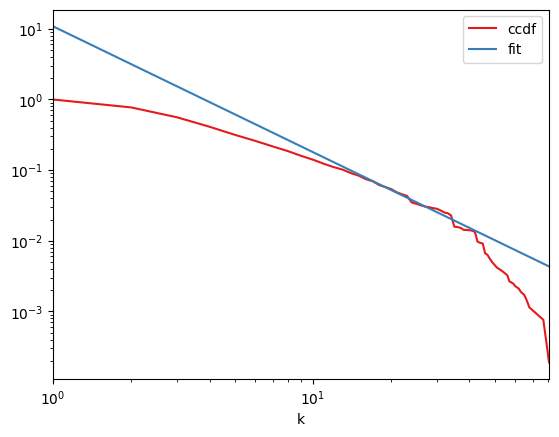

In [ ]:
degree.check_power_law(G);

## Connected Components

In [ ]:
largest_cc = max(nx.connected_components(G), key=len)
LG = G.subgraph(largest_cc)

In [ ]:
%%script echo skipping
summary.final_return_statement(LG, 5)

                   GLOBAL MEASURES                  
----------------------------------------------------
Measure                              Value
-----------------------------------  ---------------------
Number of nodes:                     4158
Number of edges:                     13428
Diameter:                            17
Density of the graph:                0.0015537345342493286
----------------                     ----------------
Five number summary of the degrees:  ----------------
Minimum degree:                      1.0
Lower Quantile:                      2.0
Median Value:                        3.0
Upper Quantile:                      7.0
Maximum degree:                      81.0
Degree Variance:                     74.42868387024231
----------------                     ----------------
Global clustering coefficient:       0.6288944756689877
Average clustering coefficient:      0.5568782161697929
Average Shortest Path:               6.049380016182999
                  

### Check for Power-law

Many networks have a power law degree distribution, but rarely this is a pure power law: it is often shifted or truncated. Fitting a power law and finding the correct exponent is tricky and you should not do it using a linear regression.

$p(k) \sim k^{-\alpha}$

In [ ]:
from scipy.stats import linregress
import numpy as np
import powerlaw as pl


# define ccdf like in the plot function.
dd = Counter(dict(G.degree).values()) # dict(degree of node: how many nodes have this degree)
dd = pd.DataFrame(list(dd.items()), columns = ("k", "count")).sort_values(by = "k")  # make df and sort values by degree, ascending
ccdf = dd.sort_values(by = "k", ascending = False) 
#^ sort degree from high to low. 

# Now we calculate the cumulative sum of the degrees, in descending order.
# So the 100% "chance" is in the beginning of the plot, as opposite the CDF
ccdf["cumsum"] = ccdf["count"].cumsum()  # cumsum= cumsum of the count of degrees
ccdf["ccdf"] = ccdf["cumsum"] / ccdf["count"].sum() # normalise the cumsum
# sort the values again by ascentding order, since k is ascending in the x-axis
# the lowest value of k is the most likely 
ccdf = ccdf[["k", "ccdf"]].sort_values(by = "k") 

# We take the logarithm in base 10 of both degree and CCDF. Then we simply do a linear regression. 
# The slope is  the exponent. The intercept needs to be the power of 10, to undo the logarithm operation. 
# Look at that r-squared!
logcdf = np.log10(ccdf[["k", "ccdf"]])
slope, log10intercept, r_value, p_value, std_err = linregress(logcdf["k"], logcdf["ccdf"])
print("CCDF Fit: %1.4f x ^ %1.4f (R2 = %1.4f, p = %1.4f)" % (10 ** log10intercept, slope, r_value ** 2, p_value))

CCDF Fit: 8.6089 x ^ -1.8811 (R2 = 0.8639, p = 0.0000)


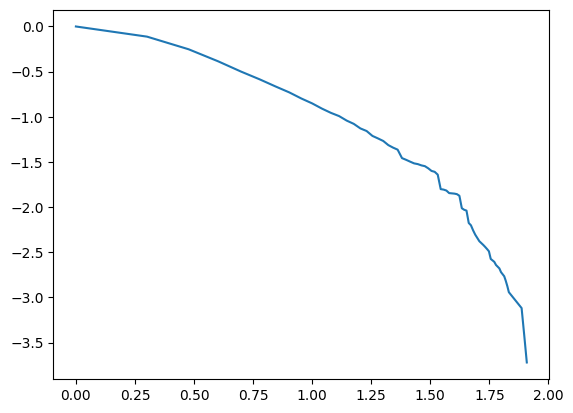

In [ ]:
plt.plot(np.log10(ccdf['k']), np.log10(ccdf['ccdf']))

In [ ]:
# With the powerlaw package, fitting the CCDf is simple. It will store results in 
# the .power_law property. To get the actual k_min, we need to find the degree value 
# corresponding to the probability in .power_law.xmin:
# pandas makes it easy. This is definitely a shifted power law. 
# (Kappa contains the intercept information)

results = pl.Fit(ccdf["ccdf"])
k_min = ccdf[ccdf["ccdf"] == results.power_law.xmin]["k"]
print("Powerlaw CCDF Fit: %1.4f x ^ -%1.4f (k_min = %d)" % (10 ** results.power_law.Kappa, results.power_law.alpha, k_min))

TypeError: 'numpy.float64' object is not iterable

In [ ]:
from scipy.stats import powerlaw
print(powerlaw.fit(ccdf['ccdf']))
print(results.power_law.alpha)

(0.23726641528943537, 0.0001907668828691339, 1.0378376800555995)
1.7803642425668489


In [ ]:
k_min # the degree with the lowest probability. Aka one of the highest degrees.

43    34
Name: k, dtype: int64

In [ ]:
results = pl.Fit(ccdf['ccdf'])
print(results.power_law.alpha)
print(results.power_law.xmin)
R, p = results.distribution_compare('power_law', 'lognormal')

1.7803642425668489
0.022892025944296072
/opt/conda/lib/python3.8/site-packages/powerlaw.py:699: RuntimeWarning: invalid value encountered in divide
  (CDF_diff**2) /


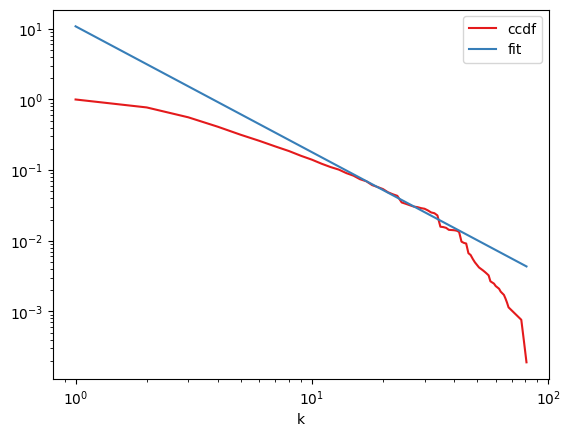

In [ ]:
#%%script echo skipping
# Let's plot the best fit.
ccdf["fit"] = (10 ** results.power_law.Kappa) * (ccdf["k"] ** -results.power_law.alpha)
ax = plt.gca()
ccdf.plot(kind = "line", x = "k", y = "ccdf", color = "#e41a1c", loglog = True, ax = ax)
ccdf.plot(kind = "line", x = "k", y = "fit", color = "#377eb8", loglog = True, ax = ax)
plt.savefig("ccdf_fit.png")

In [ ]:
print(slope)

-1.8810900986395


### Graph Density
The density of a graph is the ratio of observed edges to the number of possible edges for a network. In a graph that has 3 nodes, where all of them is connected, we would then expect $3 \cdot 2/2 = 3$ edges, and that is what we have. Its density is the maximum possible: 100%.

Another explanation count be, the number of edges in a network over the total possible number of edges that can exist given the number of nodes.

Our network/graph is undirected, so the formula we will use to calculate this is:

$d = \frac{2 \cdot |E|}{|V| \cdot  (|V| - 1)}$. We will calculate both ways, by using the formula, and by using the Network X function for density `density()`.

The density for a graph would be 0 if there are none edges, and the density for a graph would be 1 if the graph is complete. Meaning that if all the nodes was multiplied by itself, minus 1 node, then the graph would be complete and have a density of 1.

We would expect a very low density, since real world networks are very sparse. The density of a network
 goes down as you increase the number of nodes, which makes sense, since the denominator of the density formula grows quadratically.